In [1]:
from CVIP_Main_assignment import Hand_measurement
import cv2

In [2]:
Hand = Hand_measurement("handscans/Image (9).jpg","right")
image = cv2.imread("handscans/Image (9).jpg")

Morphological operations to do segmentation

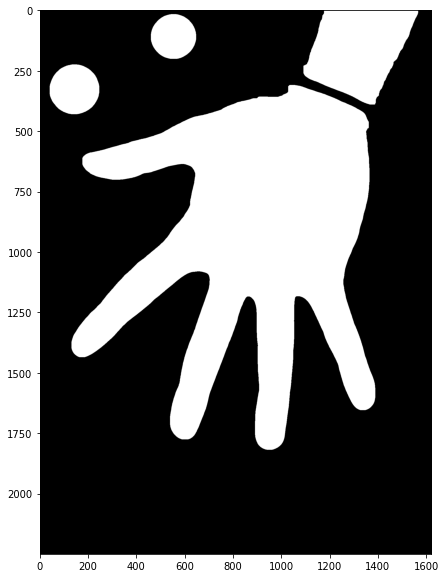

In [3]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,10)) 
plt.imshow(Hand.threshold(),cmap="gray")

Contours are found using cv2.findContours.

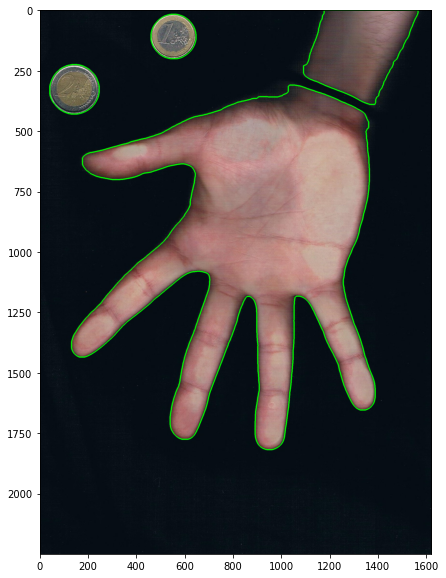

In [4]:
contours = Hand.contours
for c in Hand.contours:
    cv2.drawContours(Hand.image, contours, -1, (0,255,0), 3)
plt.figure(figsize=(10,10)) 
plt.imshow(cv2.cvtColor(Hand.image, cv2.COLOR_BGR2RGB))

Biggest contour by area (hand) is taken out and its convex hull and defects are calculated.

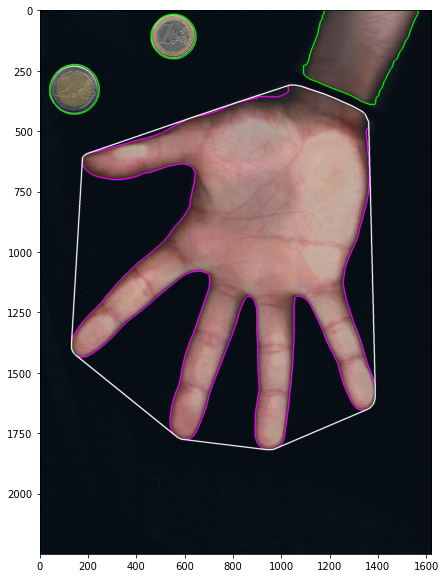

In [5]:
#Biggest area = Hand
cv2.drawContours(Hand.image, [Hand.hand], -1, (255,0,255), 3)
#Convex Hull
hull = cv2.convexHull(Hand.hand)
cv2.drawContours(Hand.image, [hull], -1, (255,255,255), 3)

plt.figure(figsize=(10,10)) 
plt.imshow(cv2.cvtColor(Hand.image, cv2.COLOR_BGR2RGB))

Finger tips are calculated by applying filtering to the defects using cosine theorem. 

In [6]:
print(Hand.finger_tips_calculation.__doc__)


        Filters convexity defects by appling Cosine Theorem; calculates the angle theta for each defect,
        if the angle theta is less than π/2, defects are appended to seperate lists. The seperate lists can be used to identify:

        Right Hand:

        Start[0] = Thumb (1)
        Start[1] = Index (2)
        Start[2] = Middle (3)
        Start[3] = Ring (4)
        End[3]  = Little  (5)
        Far[0] = Point between thumb and side of palm

        Left Hand:

        Start[0] = Little (5)
        Start[1] = Ring (4)
        Start[2] = Middle (3)
        Start[3] = Index (2)
        End[3] = Thumb (1)
        Far[3] = Point between thumb and side of palm

        Also finds center of the hand contour by using cv2.moments method.

        Returns:
            list: Startlist containing 4 of the finger tips depending on side of hand
            list: Endlist Containing remaining finger tips depending on side of hand
            list: Center of the contour
        


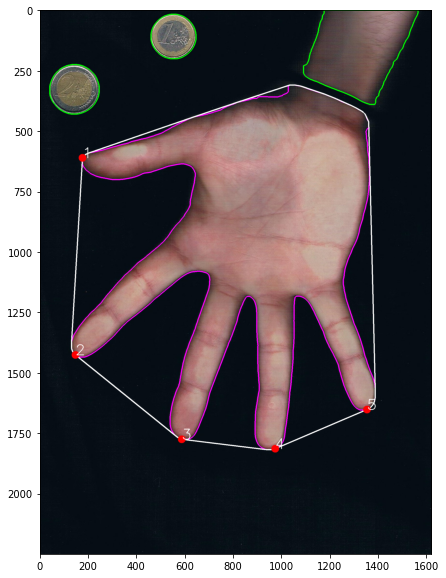

In [7]:
Hand.finger_tips()
plt.figure(figsize=(10,10)) 
plt.imshow(cv2.cvtColor(Hand.image, cv2.COLOR_BGR2RGB))

## Calculating diameter of 1 Euro coin

As the 1 Euro coin has the smallest contour area in the image, it can be selected directly from the contours list.

In the application there is also filter created according to the width and height of the image to exclude the noises if they are left after thresholding.



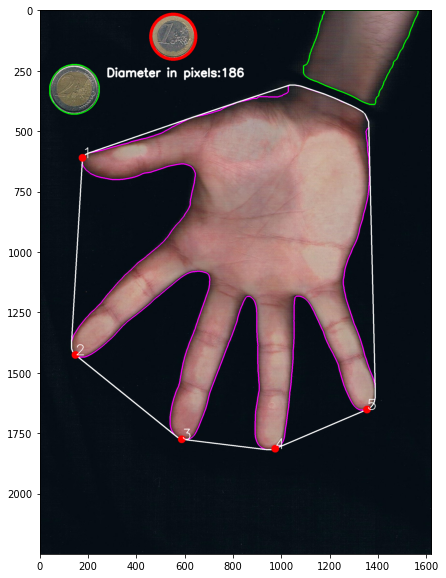

In [8]:
#This part is just for demonstrating it in this notebook. Procedure is the same in original application but here filter is excluded.
(x, y), r = cv2.minEnclosingCircle(Hand.contours[2])
center = (int(x), int(y))
radius = int(r)

#Drawing circle around reference object
cv2.circle(Hand.image, tuple(center), radius, [0, 0, 255], 12)
cv2.putText(Hand.image, str("Diameter in pixels:"+str(round(radius*2, 2))),
            tuple((int(x*0.5), int(y * 2.5))), cv2.FONT_HERSHEY_SIMPLEX, 1.6,
            (255, 255, 255),
            5, cv2.LINE_AA)
plt.figure(figsize=(10,10)) 
plt.imshow(cv2.cvtColor(Hand.image, cv2.COLOR_BGR2RGB))

### Measuring the distance between fingers 1-3:

A corner in the smallest bounding box is defined with X coordinate of Fingertip 1 and Y coordinate of Fingertip 3.

After that euclidean distance between this point to fingertip 1 is calculated by using ppm_to metric method which takes euclidean distance between two points and divides the difference to the resulting ppM from reference object

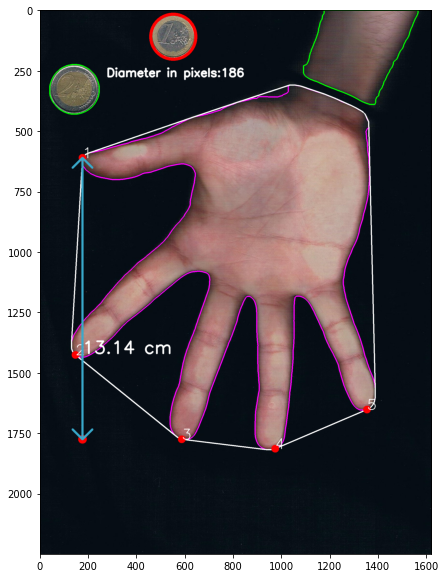

In [9]:
top_corner = (Hand.fingers[0][0], Hand.fingers[2][1])
#Top corner shown as red circle on tip of arrow
cv2.circle(Hand.image, tuple(top_corner), 18, [0, 0, 255], -1)
#Line showing the distance between Finger 1-3
cv2.arrowedLine(Hand.image, tuple(top_corner), Hand.fingers[0], (203, 169, 57), 8, tipLength=0.05)
cv2.arrowedLine(Hand.image, Hand.fingers[0], tuple(top_corner), (203, 169, 57), 8, tipLength=0.05)

#Calculating the distance
distance = Hand.ppm_to_metric(top_corner, Hand.fingers[0])

#Putting it as text
cv2.putText(Hand.image, str(str(round(distance, 2)) + " cm"),
            tuple((top_corner[0], int(top_corner[1] * 0.8))), cv2.FONT_HERSHEY_SIMPLEX, 2.4, (255, 255, 255),
            5, cv2.LINE_AA)
plt.figure(figsize=(10,10)) 
plt.imshow(cv2.cvtColor(Hand.image, cv2.COLOR_BGR2RGB))

### Measuring the distance between fingers 5-3:

Same procedure with taking the distance between fingertips 1-3 is applied. Only finger number has been changed. (1 to 5)

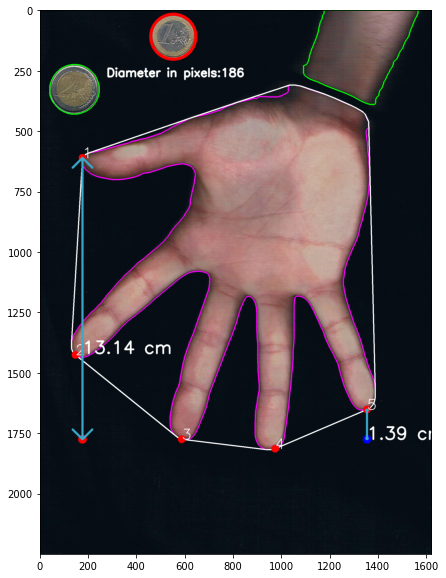

In [10]:
top_corner = (Hand.fingers[4][0], Hand.fingers[2][1])
#Top corner shown as blue circle on tip of arrow
cv2.circle(Hand.image, tuple(top_corner), 18, [255, 0, 0], -1)
#Line showing the distance between Finger 1-3
cv2.arrowedLine(Hand.image, tuple(top_corner), Hand.fingers[4], (203, 169, 57), 8, tipLength=0.05)
cv2.arrowedLine(Hand.image, Hand.fingers[4], tuple(top_corner), (203, 169, 57), 8, tipLength=0.05)

#Calculating the distance
distance = Hand.ppm_to_metric(top_corner, Hand.fingers[4])

#Putting it as text
cv2.putText(Hand.image, str(str(round(distance, 2)) + " cm"),
            tuple((top_corner[0], int(top_corner[1] * 1))), cv2.FONT_HERSHEY_SIMPLEX, 2.4, (255, 255, 255),
            5, cv2.LINE_AA)
plt.figure(figsize=(10,10)) 
plt.imshow(cv2.cvtColor(Hand.image, cv2.COLOR_BGR2RGB))

### Measuring the hand length

The hand length is defined as vertical line going from tip of middle finger to the wrist, as the point for tip of middle finger is known, only point on the wrist is needed.

While fingers are pointing downwards in the image, the highest point in the hand contour will be a point on the wrist. This points Y coordinate can be combined with the hand contours center's X coordinate to find reasonable reference point on the wrist.

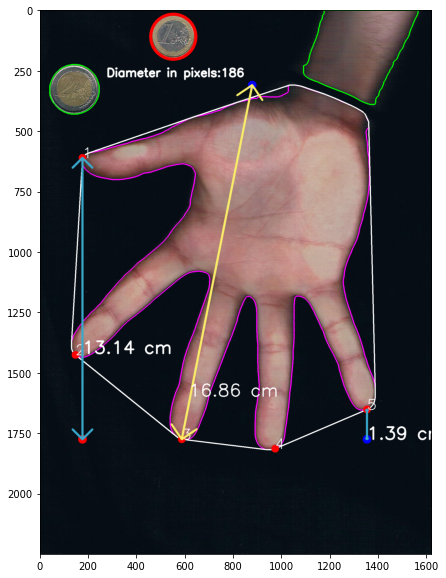

In [11]:
#Highest point in hand contour, point on wrist
extTop = tuple(Hand.hand[Hand.hand[:, :, 1].argmin()][0])
#Combining center of the hand contour with this point
bottom = [Hand.center[0], extTop[1]]
#Drawing circle on this point
cv2.circle(Hand.image, tuple(bottom), 18, [255, 0, 0], -1)
#Drawing arrowed line between this point and tip of middle finger
cv2.arrowedLine(Hand.image, tuple(bottom), Hand.fingers[2], (105, 237, 249), 8, tipLength=0.05)
cv2.arrowedLine(Hand.image, Hand.fingers[2], tuple(bottom), (105, 237, 249), 8, tipLength=0.05)
#Calculating the euclidean distance between two points.
distance = Hand.ppm_to_metric(bottom, Hand.fingers[2])
#Putting it as text to the image
cv2.putText(Hand.image, str(str(round(distance, 2)) + " cm"),
            tuple((int(Hand.fingers[2][0] * 1.05), int(Hand.fingers[2][1] * 0.90))),
            cv2.FONT_HERSHEY_SIMPLEX, 2.4, (255, 255, 255), 4, cv2.LINE_AA)
plt.figure(figsize=(10,10)) 
plt.imshow(cv2.cvtColor(Hand.image, cv2.COLOR_BGR2RGB))

### Measuring the hand width

After filtering the defects with cosine theorem, points in the gaps between the finger are appended to a list.

Depending on the side of the hand either 4th or first array in this list is the point between thumb and index finger. This point is relatebly close to a point in center of the palm. This is taken as first point to measure hand width.

To find the second point, contour of the hand is filtered such that only contours in range(95% to 110%) of the first point's Y value are appended to the list. 

Also to reduce mistakes during finding this point, contours which has bigger (left side) or lower (right side) X values then first point are discarded.

After finding this point the euclidean distance between two points are calculated.

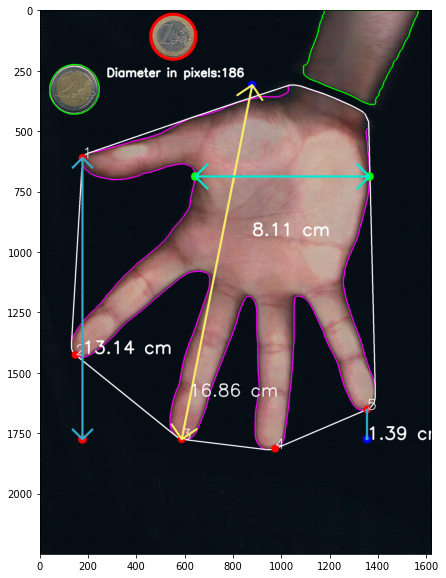

In [12]:
#First Point in green circle
cv2.circle(Hand.image, tuple(Hand.palm_side[0]), 18, [0, 255, 0], -1)


side = []

for c in Hand.hand:
    for n in c:
        if n[1] >= int(Hand.palm_side[0][1] * 0.95) and n[1] <= int(Hand.palm_side[0][1] * 1.05):
            if not n[0] < int(Hand.palm_side[0][0]):
                side.append(c)
side = side[::-1]
#Second point in green circle also
side_ref = tuple((side[0][0][0], Hand.palm_side[0][1]))
cv2.circle(Hand.image, tuple(side_ref), 18, [0, 255, 0], -1)


cv2.arrowedLine(Hand.image, side_ref, Hand.palm_side[0], (211, 234, 0), 8, tipLength=0.1)
cv2.arrowedLine(Hand.image, Hand.palm_side[0], side_ref, (211, 234, 0), 8, tipLength=0.1)

distance = Hand.ppm_to_metric(Hand.palm_side[0], side_ref)
cv2.putText(Hand.image, str(str(round(distance, 2)) + " cm"),
            tuple((int(Hand.center[0]), int(Hand.center[1] * 0.97))), cv2.FONT_HERSHEY_SIMPLEX, 2.4,
            (255, 255, 255),
            5, cv2.LINE_AA)

plt.figure(figsize=(10,10)) 
plt.imshow(cv2.cvtColor(Hand.image, cv2.COLOR_BGR2RGB))